In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.utils.utils import zero_pad
from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_initial_draw import kalman_initial_draw
from probDE.Kalman import kalman_ode_higher
from probDE.Kalman.higher_mvncond import higher_mvncond
from kalman_ode_higher import kalman_ode_higher as kalman_ode_higher_cy
from linalg.mat_mult import mat_mult, mat_vec_mult

In [2]:
%load_ext Cython

In [3]:
%%cython
from libc.math cimport sin
import numpy as np
cimport numpy as np
cpdef ode_fun(double[::1] x_t, double t):
    return sin(2*t) - x_t[0]

In [4]:
def chk_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

def chk_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In [5]:
N = 50
q = 2
p = q+2
tmin = 0
tmax = 10
delta_t = np.array([(tmax-tmin)*1/N])
w = np.array([0. , 0., 1.])
wgt_meas = zero_pad(w, p)
x0 = np.array([-1., 0., 0.])
x0 = np.array([-1.0, 0.0, ode_fun(x0, 0)]) #Initial state
r0 = 500
sigma = 0.5
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
x_0 = kalman_initial_draw(roots, sigma, x0, p)
wgt_state, var_state = higher_mvncond(delta_t, roots, sigma) 
mu_state = np.zeros(p)

Yn, Yn_chk_mean, Yn_chk_var = kalman_ode_higher(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas)

In [6]:
%%cython
import numpy as np
cimport numpy as np
cpdef rand_mat(int n, int p, bint pd=True):
    cdef np.ndarray[np.double_t, ndim=2] V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) and pd:
        V[:] = np.matmul(V, V.T)
    return V

In [7]:
z_state_sim = rand_mat(2*N, p)

In [ ]:
%%cython -a
cimport cython
import numpy as np
cimport numpy as np
from kalmantv.cython import KalmanTV
from linalg.mat_mult import mat_mult, mat_vec_mult

DTYPE = np.double
ctypedef np.double_t DTYPE_t

# FIXME: where should we be using memory views?  most likely in the inputs,
# but is there a risk of overwriting things?
# anywhere else?
# FIXME: need to replace all calls to np.linalg with low-level C calls.
# I can think of two ways to do this:
# 1.  Use BLAS/LAPACK numpy interface.  see `cython-linalg.ipynb`.
# 2.  Write a C++ class in Eigen to handle the remaining linalg operations.  For example:
#
#    ```
#    class LinalgUtils {
#    }
#    ```
#
#    The main issue here is that you should malloc everything at object instantiation time, so you'll need to specify the dimensions of all relevant operations.

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef kalman_ode_higher_cy(fun,
                          double[::1] x0_state,
                          double tmin,
                          double tmax,
                          int n_eval, 
                          double[::1, :] wgt_state,
                          double[::1] mu_state, 
                          double[::1, :] var_state,
                          double[::1, :] wgt_meas, 
                          double[::1, :] z_state_sim,
                          bint smooth_mv=True,
                          bint smooth_sim=True):
    # Dimensions of state and measure variables
    cdef int n_dim_meas = wgt_meas.shape[0]
    cdef int n_dim_state = mu_state.shape[0]
    cdef int n_steps = n_eval + 1

    # argumgents for kalman_filter and kalman_smooth
    cdef np.ndarray[DTYPE_t, ndim=1] mu_meas = np.zeros(n_dim_meas,
                                                        dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=3] var_meass = np.zeros((n_dim_meas, n_dim_meas, n_steps),
                                                          dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=2] x_meass = np.zeros((n_dim_meas, n_steps),
                                                        dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=2] mu_state_filts = np.zeros((n_dim_state, n_steps),
                                                               dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=3] var_state_filts = np.zeros((n_dim_state, n_dim_state, n_steps),
                                                                dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=2] mu_state_preds = np.zeros((n_dim_state, n_steps),
                                                               dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=3] var_state_preds = np.zeros((n_dim_state, n_dim_state, n_steps),
                                                                dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=2] mu_state_smooths = np.zeros((n_dim_state, n_steps),
                                                                 dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=3] var_state_smooths = np.zeros((n_dim_state, n_dim_state, n_steps),
                                                                  dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=2] x_state_smooths = np.zeros((n_dim_state, n_steps),
                                                                dtype=DTYPE, order='F')
    cdef np.ndarray[DTYPE_t, ndim=1] x_state_tt = np.zeros(n_dim_state, 
                                                           dtype=DTYPE, order='F') #Temporary state simulation for interrogation
    cdef np.ndarray[DTYPE_t, ndim=2] var_state_meas = np.zeros((n_dim_meas, n_dim_state),
                                                           dtype=DTYPE, order='F') #Temporary matrix for multi_dot
    cdef int t
    
    # initialize things
    mu_state_filts[:, 0] = x0_state
    mat_vec_mult(wgt_meas, x0_state, x_meass[:, 0].T)
    mu_state_preds[:, 0] = mu_state_filts[:, 0]
    var_state_preds[:, :, 0] = var_state_filts[:, :, 0]
    # forward pass
    ktv = KalmanTV(n_dim_meas, n_dim_state)
    for t in range(n_eval):
        # kalman filter:
        # 1. predict
        ktv.predict(mu_state_pred = mu_state_preds[:, t+1],
                    var_state_pred = var_state_preds[:, :, t+1],
                    mu_state_past = mu_state_filts[:, t],
                    var_state_past = var_state_filts[:, :, t],
                    mu_state = mu_state,
                    wgt_state = wgt_state,
                    var_state = var_state)
        # 2. chkrebtii interrogation
        mat_mult(wgt_meas, var_state_preds[:, :, t+1], var_state_meas)
        mat_mult(var_state_meas, wgt_meas.T, var_meass[:, :, t+1])
        ktv.state_sim(x_state_tt, 
                      mu_state_preds[:, t+1], 
                      var_state_preds[:, :, t+1], 
                      z_state_sim[:, t])
        x_meass[:, t+1] = fun(x_state_tt, tmin + (tmax-tmin)*(t+1)/n_eval)
        # 3. update
        ktv.update(mu_state_filt = mu_state_filts[:, t+1],
                   var_state_filt = var_state_filts[:, :, t+1],
                   mu_state_pred = mu_state_preds[:, t+1],
                   var_state_pred = var_state_preds[:, :, t+1],
                   x_meas = x_meass[:, t+1],
                   mu_meas = mu_meas,
                   wgt_meas = wgt_meas,
                   var_meas = var_meass[:, :, t+1])

    # backward pass
    mu_state_smooths[:, n_eval] = mu_state_filts[:, n_eval]
    var_state_smooths[:, :, n_eval] = var_state_filts[:, :, n_eval]
    ktv.state_sim(x_state_smooths[:, n_eval], 
                  mu_state_smooths[:, n_eval], 
                  var_state_smooths[:, :, n_eval],
                  z_state_sim[:, 2*n_eval+1])

    for t in reversed(range(n_eval)):
        '''
        ktv.smooth(x_state_smooth = x_state_smooths[:, t],
                   mu_state_smooth = mu_state_smooths[:, t],
                   var_state_smooth = var_state_smooths[:, :, t], 
                   x_state_next = x_state_smooths[:, t+1],
                   mu_state_next = mu_state_smooths[:, t+1],
                   var_state_next = var_state_smooths[:, :, t+1],
                   mu_state_filt = mu_state_filts[:, t],
                   var_state_filt = var_state_filts[:, :, t],
                   mu_state_pred = mu_state_preds[:, t+1],
                   var_state_pred = var_state_preds[:, :, t+1],
                   wgt_state = wgt_state,
                   z_state = z_state_sim[:, n_eval+t])
        '''
        if smooth_mv:
            ktv.smooth_mv(mu_state_smooth = mu_state_smooths[:, t],
                          var_state_smooth = var_state_smooths[:, :, t],
                          mu_state_next = mu_state_smooths[:, t+1],
                          var_state_next = var_state_smooths[:, :, t+1],
                          mu_state_filt = mu_state_filts[:, t],
                          var_state_filt = var_state_filts[:, :, t],
                          mu_state_pred = mu_state_preds[:, t+1],
                          var_state_pred = var_state_preds[:, :, t+1],
                          wgt_state = wgt_state)
        if smooth_sim:
            ktv.smooth_sim(x_state_smooth = x_state_smooths[:, t],
                           x_state_next = x_state_smooths[:, t+1],
                           mu_state_filt = mu_state_filts[:, t],
                           var_state_filt = var_state_filts[:, :, t],
                           mu_state_pred = mu_state_preds[:, t+1],
                           var_state_pred = var_state_preds[:, :, t+1],
                           wgt_state = wgt_state,
                           z_state = z_state_sim[:, n_eval+t])
            
    if smooth_mv and smooth_sim:
        return x_state_smooths, mu_state_smooths, var_state_smooths
    elif smooth_mv:
        return mu_state_smooths, var_state_smooths
    else:
        return x_state_smooths


In [8]:
Yn2, Yn_chk_mean2, Yn_chk_var2 = kalman_ode_higher_cy(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

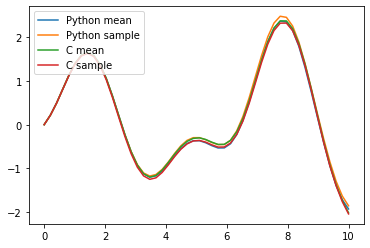

In [9]:
tseq = np.linspace(tmin, tmax, N)
plt.plot(tseq, Yn_chk_mean[:, 1], label = 'Python mean')
plt.plot(tseq, Yn[:, 1], label = 'Python sample')
plt.plot(tseq, Yn_chk_mean2[1], label = 'C mean')
plt.plot(tseq, Yn2[1], label = 'C sample')
plt.legend(loc='upper left')

## Python, Cython, Odeint Timings

In [24]:
py = %timeit -o -n 100 Yn, Yn_chk_mean, Yn_chk_var = \
    kalman_ode_higher(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas)

18.7 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
cy = %timeit -o -n 100 Yn2, Yn_chk_mean2, Yn_chk_var2 = \
    kalman_ode_higher_cy(ode_fun, x_0, tmin, tmax, N-1, wgt_state, mu_state, var_state, wgt_meas, z_state_sim)

2.5 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
py.average/cy.average

7.493639999947428

In [19]:
from scipy import integrate
from math import sin
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [20]:
ode = %timeit -o ode = integrate.odeint(f, [-1, 0], tseq)
cy.average/ode.average

525 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


4.734160891671725

## Python to Cython Comparisons of `fun` and `rand_mat`

In [ ]:
def rand_mat_py(n, p=None, pd=True):
    """Generate a random matrix, positive definite if `pd = True`."""
    if p is None:
        p = n
    V = np.zeros((p, n), order='F')
    V[:] = np.random.randn(p, n)
    if (p == n) & pd:
        V[:] = np.matmul(V, V.T)
    return V

In [ ]:
%timeit rand_mat(2*N, p)

In [ ]:
%timeit rand_mat_py(2*N, p)

In [ ]:
def ode_fun_py(x_t, t):
    return sin(2*t) - x_t[0]

In [ ]:
%timeit ode_fun(x_0, 0)

In [ ]:
%timeit ode_fun_py(x_0, 0)

## Blas/Lapack

In [ ]:
def rel_err(X1, X2):
    """Relative error between two numpy arrays."""
    return np.max(np.abs((X1.ravel() - X2.ravel())/X1.ravel()))

In [ ]:
m = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,n), order='F')
x = np.random.rand(n)
y = np.zeros(m, order='F')

In [ ]:
mat_vec_mult(A, x, y)
np.testing.assert_almost_equal(rel_err(A.dot(x), y), 0.0)

In [ ]:
m = np.random.randint(2,10)
k = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,k), order='F')
B = np.array(np.random.rand(k,n), order='F')
C = np.zeros((m,n), order='F')

In [ ]:
mat_mult(A, B, C)
np.testing.assert_almost_equal(rel_err(np.matmul(A, B), C), 0.0)

## Numpy vs Blas Timings

In [ ]:
m = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,n), order='F')
x = np.random.rand(n)
y = np.zeros(m, order='F')

In [ ]:
%timeit np.dot(A, x)

In [ ]:
%timeit mat_vec_mult(A, x, y)

In [ ]:
m = np.random.randint(2,10)
k = np.random.randint(2,10)
n = np.random.randint(2,10)
A = np.array(np.random.rand(m,k), order='F')
B = np.array(np.random.rand(k,n), order='F')
C = np.zeros((m,n), order='F')

In [ ]:
%timeit np.matmul(A, B)

In [ ]:
%timeit mat_mult(A, B, C)